# Classification

In [5]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from tqdm import tqdm

plt.ion()

## Data Preperation

In [6]:
import sys
sys.path.append('../../data')
from corpus import load_corpus
data = load_corpus('newsela')

X_train = data['X_train']
y_train = data['y_train']
y_train_onehot = data['y_train_onehot']
X_test = data['X_test']
y_test = data['y_test']
y_test_onehot = data['y_test_onehot']

## Classical ML

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


def train_classification_model(model_class, X_train, y_train, model_params={}, hyperparameters_grid={}):
    
    name = model_class.__name__
    
    if 'kernel' in model_params:
        name += ' ' + model_params['kernel']
    
    model = model_class(random_state=42, **model_params)
    if hyperparameters_grid:
        model = GridSearchCV(model, hyperparameters_grid)
        
    model.fit(X_train, y_train)
        
    return name, model


Cs = 10.**np.arange(-4, 5)
    
models = dict([train_classification_model(model_class, X_train, y_train, model_params, hyperparameters_grid)
          for model_class, model_params, hyperparameters_grid in
                                     tqdm([
                                         (LogisticRegressionCV, {},  {}),
                                         (LinearSVC, {}, {'C': Cs}),
                                         (SVC, {'kernel': 'rbf', 'probability': True}, {'C': Cs}),
                                         (SVC, {'kernel': 'poly', 'probability': True}, {'C': Cs}),
                                         (SVC, {'kernel': 'sigmoid', 'probability': True}, {'C': Cs}),
                                         (RandomForestClassifier, {}, {'n_estimators': range(10, 101, 10),
                                                                  'max_features': ['auto', 'sqrt'],
                                                                  'max_depth': range(10, 101, 10)}),
                                        (GradientBoostingClassifier, {}, {}),
                                     ])])

100%|██████████| 7/7 [1:48:32<00:00, 930.30s/it] 


## MLP

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

n_features = X_train.shape[1]

def train_mlp(units):
    model = Sequential()
    model.add(Dense(units, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(13, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train_onehot, epochs=30, verbose=0)#, validation_split=0.1,)
    
    return model


models['MLP 16'] = train_mlp(16)
models['MLP 32'] = train_mlp(32)
models['MLP 64'] = train_mlp(64)
models['MLP 128'] = train_mlp(128)

In [15]:
deep_model = Sequential()
deep_model.add(Dense(256, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(13, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

deep_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

deep_model.fit(X_train, y_train_onehot, epochs=100, verbose=0)

models['MLP-deep'] = deep_model

## Evaluation

In [16]:
import itertools
import functools
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

def predict_classes(model, X_test):
    if hasattr(model, 'predict_classes'):
        y_pred = model.predict_classes(X_test)
    else:
        y_pred = model.predict(X_test)

    return y_pred
    
def calc_metrics(model, X_test, y_test):
    y_pred = predict_classes(model, X_test)
    
    return {metrics.__name__: metrics(y_test, y_pred) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]}

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()}).transpose()
evaluation_df = evaluation_df.sort_values('threshold_socre', ascending=False)

/home/users/shlohod/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
summary_evaluation_df = evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre']].astype(float).round(4)
summary_evaluation_df

,accuracy_score,f1_score_micro,threshold_socre
SVC rbf,0.7464,0.7464,0.9287
MLP-deep,0.7287,0.7287,0.9179
MLP 128,0.6760,0.6760,0.9128
SVC poly,0.7007,0.7007,0.9112
MLP 32,0.6742,0.6742,0.9100
GradientBoostingClassifier,0.7058,0.7058,0.9086
MLP 64,0.6599,0.6599,0.9040
MLP 16,0.6710,0.6710,0.9031
RandomForestClassifier,0.6892,0.6892,0.9024
LogisticRegressionCV,0.6248,0.6248,0.8606


In [18]:
summary_evaluation_df.to_excel('classification_evaluation.xlsx')

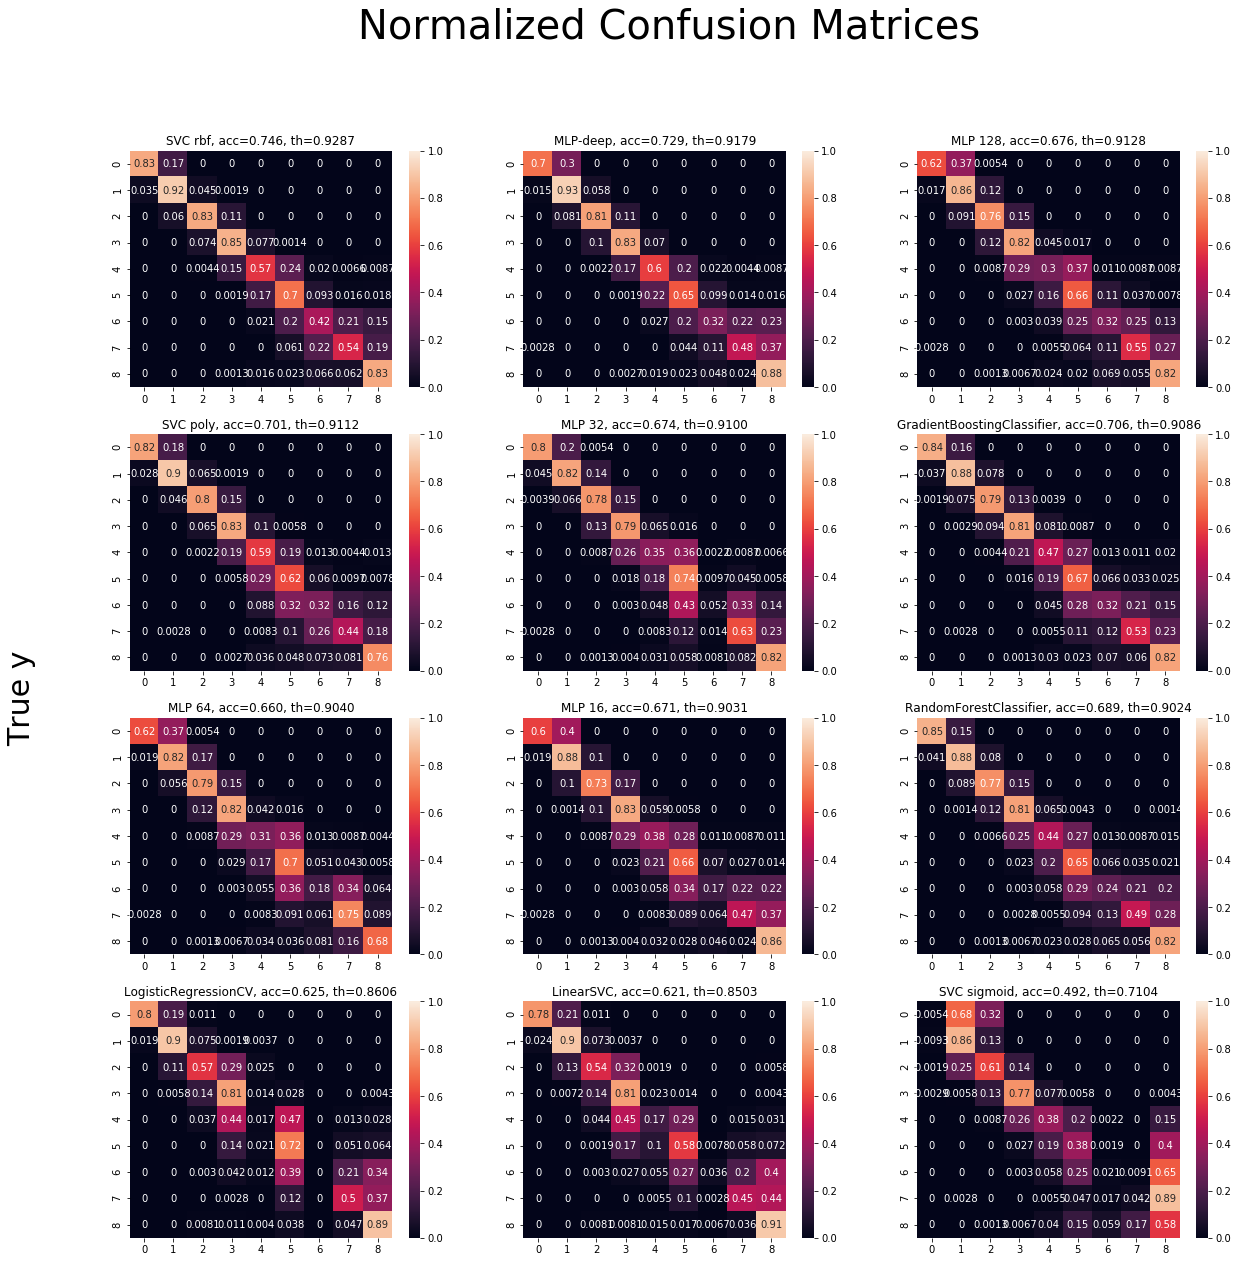

In [19]:
f, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df.iterrows(), axes):
    cm = r['confusion_matrix']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmin=0, vmax=1, annot=True,
                ax=ax)
    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))

f.text(0.04, 0.5, 'True y', va='center', rotation='vertical', fontsize=30)
f.suptitle('Normalized Confusion Matrices', fontsize=40);

### Probs Analysis

In [52]:
"""
f, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df.iterrows(), axes):

    model = models[name]
    try:
        y_pred_probs = model.predict_proba(X_test)
    except AttributeError:
        continue
    
    assert np.allclose(y_pred_probs.sum(axis=1), 1)
    
    sns.distplot(np.choose(y_test, y_pred_probs.T), label='hit', ax=ax)


    sns.distplot(np.array([[prob for index, prob in enumerate(probs) 
                      if cls != index ]
                 for probs, cls in  zip(y_pred_probs, y_test)]).flatten(),
             label='miss', ax=ax)

    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))
    ax.legend()
    
for ax in axes:
    ax.set_visible(False)
    
f.suptitle('Dist hit/miss probs', fontsize=40);
"""

"\nf, axes = plt.subplots(3, 3, figsize=(20, 15))\naxes = itertools.chain(*axes)\nfor (name, r), ax in zip(evaluation_df.iterrows(), axes):\n\n    model = models[name]\n    try:\n        y_pred_probs = model.predict_proba(X_test)\n    except AttributeError:\n        continue\n    \n    assert np.allclose(y_pred_probs.sum(axis=1), 1)\n    \n    sns.distplot(np.choose(y_test, y_pred_probs.T), label='hit', ax=ax)\n\n\n    sns.distplot(np.array([[prob for index, prob in enumerate(probs) \n                      if cls != index ]\n                 for probs, cls in  zip(y_pred_probs, y_test)]).flatten(),\n             label='miss', ax=ax)\n\n    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))\n    ax.legend()\n    \nfor ax in axes:\n    ax.set_visible(False)\n    \nf.suptitle('Dist hit/miss probs', fontsize=40);\n"

### Average y as Regression

In [60]:
y_labels = y_test.unique()
y_labels.sort()

In [63]:
    y_pred_probs = model.predict_proba(X_test)


(4334, 9)

In [61]:
import itertools
import functools
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score,\
                            classification_report, accuracy_score, confusion_matrix, f1_score


def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

   
def calc_metrics(model, X_test, y_test):
    y_pred_probs = model.predict_proba(X_test)
    y_pred_avg = (y_pred_probs * y_labels).sum(axis=1)#np.arange(9)).sum(axis=1)
    y_pred_avg_classes = y_pred_avg.round().clip(0, 12).astype(int)

    metrics = {}

    metrics.update({metrics.__name__: metrics(y_test, y_pred_avg) for metrics in [mean_absolute_error,
                                                                      mean_squared_error,
                                                                      explained_variance_score,                                                                      explained_variance_score,
                                                                      r2_score
                                                                      
    ]})
    
    metrics.update({metrics.__name__: metrics(y_test, y_pred_avg_classes) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]})

    return metrics

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()
                             if name not in ['LinearSVC', 'SVC']}).transpose()
evaluation_df = evaluation_df.sort_values('threshold_socre', ascending=False)

/home/users/shlohod/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: operands could not be broadcast together with shapes (4334,13) (9,) 

In [ ]:
summary_evaluation_df = (evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre', 'mean_squared_error', 'mean_absolute_error', 'explained_variance_score', 'r2_score']]
     .astype(float).round(4))
summary_evaluation_df

In [ ]:
summary_evaluation_df.to_excel('probs_avg_classification_evaluation.xlsx')